# !\#$\@: An obscene journey through quotations in media
## ADA: Project Milestone 2
#### Group: k-beans

This notebook contains the initial analysis carried out for our project titled: **"!#$@: An obscene journey through quotations in media"**. 

For that matter, we install the requirements for the project, we load the data and we handle, explore and visualize it in order to understand it better and gain some insights. Specifically, we perform different analysis at quote, speaker and media source level, as they will be very important elements in our study. Moreover, the profanity score - which is the essence and main motivation for this project - is computed for all quotes considered and its presence in the dataset is analyzed as well, regarding different aspects. Time will also be considered as a relevant factor for the study. Finally, a small sentiment analysis experiment will be carried out so that we can present a clear idea of all different methods which are going to be used.

Note: this initial analysis has been executed for 2020 quotebank data only for performance and flexibility aspects, it will be applied to the rest of the data for the next milestone.

## Requirements

In [1]:
!pip install pyspark==3.1.1 pyarrow tldextract nltk
!pip install sparknlp
!pip install alt-profanity-check

  Using cached pyspark-3.1.1-py2.py3-none-any.whl
  Using cached py4j-0.10.9-py2.py3-none-any.whl (198 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.2
    Uninstalling py4j-0.10.9.2:
      Successfully uninstalled py4j-0.10.9.2
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.1.2
    Uninstalling pyspark-3.1.2:
      Successfully uninstalled pyspark-3.1.2
  Using cached sparknlp-1.0.0-py3-none-any.whl (1.4 kB)


## Imports

In [9]:
# Make sure that spark uses the same python distribution to avoid serialization issues due to missing packages
%env PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python

env: PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python


In [10]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [11]:
# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

#Spark NLP
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# Helpers
import os
import json

# External libraries
import profanity_check
import tldextract

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/MDS/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Spark

In [13]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
spark

## Load data

In [16]:
DATA_DIR    = 'data/'
QB_DATA_DIR = DATA_DIR + 'quotebank_data/'

QB_DATA_JSON_PATH     = QB_DATA_DIR + 'json/quotes-%s.json'
QB_DATA_JSON_BZ2_PATH = QB_DATA_DIR + 'json/quotes-%s.json.bz2'
QB_DATA_PARQUET_PATH  = QB_DATA_DIR + 'parquet/quotes-%s.parquet'

# QB_DATA_PROC_PATH contains qb data with profanity scores, tlds, prominent speaker qid, prominent speaker prob, prominent speaker label
QB_DATA_PROC_PATH     = QB_DATA_DIR + 'processed/quotes-%s.parquet' 

SPK_ATTR_PATH             = DATA_DIR + 'speaker_attributes.parquet'
SPK_ATTR_WITH_LABELS_PATH = DATA_DIR + 'speaker_attributes_with_labels.parquet'

LABELS_PATH = DATA_DIR + 'wikidata_labels_descriptions_quotebank.csv.bz2'

YEARS = ['2020']


In [17]:
QB_JSON_SCHEMA = StructType.fromJson(json.loads(
    '''{  "type": "struct", 
        "fields": [
            {"name": "date", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "numOccurrences", "type": "long", "nullable": true,"metadata": {}}, 
            {"name": "phase", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "probas", "type": 
            {"type": "array", "elementType": {"type": "array", "elementType": "string", "containsNull": true}, "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "qids", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "quotation", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "quoteID", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "speaker", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "urls", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}
            ]
    }'''))


### Load the labels of QIDS

In [18]:
labels = pd.read_csv(LABELS_PATH)
labels = labels.set_index("QID")

## Analysis of Speaker Attributes

We are given a dataset on all speakers whose quotes appear in the qutoebank data from 2015-2020. In the following, we do a general analysis of this dataset.

In [19]:
spk_attr = spark.read.parquet(SPK_ATTR_PATH)
", ".join(spk_attr.columns)

'aliases, date_of_birth, nationality, gender, lastrevid, ethnic_group, US_congress_bio_ID, occupation, party, academic_degree, id, label, candidacy, type, religion'

In [20]:
spk_attr.count()

9055981

In [26]:
spk_summary = pd.DataFrame( { 'non_null_count' : [ spk_attr.where(spk_attr[col].isNotNull()).count() for col in spk_attr.columns ] },
                           index=spk_attr.columns )
spk_summary

,non_null_count
aliases,1203402
date_of_birth,5017333
nationality,3715852
gender,7105600
lastrevid,9055981
ethnic_group,130385
US_congress_bio_ID,12874
occupation,6373084
party,399176
academic_degree,99995


We have speaker attributes provided for 9055981 many speakers, and following fields of data are provided:
1. aliases
2. date_of_birth
3. nationality
4. gender
5. lastrevid
6. ethnic_group
7. US_congress_bio_ID
8. occupation
8. party
9. academic_degree
10. id
11. label
12. candidacy
13. type
14. religion

For the fields, 'nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion', the provided data are in terms of the wiki-data identifiers. So we first extend the dataset by addinng new columns with the human readable labels, using the labels dataset.
We save the new augmented data set in *parquet* format.

### Extending speaker attributes with labels

In [25]:
def qids_to_attr_labels(qids):
    """Returns the list of labels corresponding the each qid in the given list"""
    if qids is None or len(qids) == 0:
        return []
    return list(map(lambda qid : labels.Label[qid] if qid in labels.index else qid, qids))

def map_missing(iterator):
    """Applys qids_to_attr_labels to the data"""
    for df in iterator:
        for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
            df[col + '_labels'] = df[col].apply(qids_to_attrib_labels)
        yield df
        
def expand_spk_attr_with_labels():
    spk_attr = spark.read.parquet(SPK_ATTR_PATH)
    for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
        spk_attr = spk_attr.withColumn(col + '_labels', spk_attr[col])
    spk_attr.write.parquet(SPK_ATTR_WITH_LABELS_PATH, 'overwrite')

In [ ]:
# Uncomment for the first-run to save the processed files
# expand_spk_attr_with_labels()

**Note:** From this point onward, we use the speaker attributes extended with human readable labels.

In [23]:
# Load expanded data
spk_attr = spark.read.parquet(SPK_ATTR_WITH_LABELS_PATH)

## Analysis of Quotebank Data

Load the raw quotebank dataset. Note that so far, we only consider 2020 dataset, but the pipeline supports all data.

In [33]:
# Join the data from all the years - to be used later
qb_raw = spark.read.parquet(QB_DATA_PARQUET_PATH % YEARS[0])
for y in YEARS[1:]:
    qb_raw = qb_raw.union(spark.read_parquet(QB_DATA_PARQUET_PATH % y))

In [29]:
", ".join(qb_raw.columns)

'date, numOccurrences, phase, probas, qids, quotation, quoteID, speaker, urls'

In [34]:
qb_raw.count()

5244449

In [30]:
@f.udf(returnType=BooleanType())
def is_not_none_or_not_empty(val):
    if val is None:
        return False
    if val == "None":
        return False
    return True

In [31]:
qb_summary = pd.DataFrame( { 'non_null_count' : [ qb_raw.where(is_not_none_or_not_empty(col)).count() for col in qb_raw.columns ] }, index=qb_raw.columns )
qb_summary

,non_null_count
date,5244449
numOccurrences,5244449
phase,5244449
probas,5244449
qids,5244449
quotation,5244449
quoteID,5244449
speaker,3443605
urls,5244449


The 2020 dataset contains 5244449 entries but only 3443605 entries are associated with a speaker. For our analysis, we augment the dataset with a few additional fields.

1. profanity - this field contains the profanity score computed by the package 'alt-profanity-check'.
2. speaker_qid - the qid of the speaker that has the highest probability value.
3. speaker_label - label of the speaker who is associated with 'speaker_qid'.
4. speaker_prob - the probability associated with 'speaker_qid'
5. tld - top-level-domain names of extracted from the url list using 'tldextract' package.


### Extending quotebank dataset with additional columns

In [42]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None

def fill_columns(iterator):
    for df in iterator:
        df['profanity']     = profanity_check.predict_prob(df.quotation)
        df['speaker_qid']   = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else qids[0])         
        df['speaker_prob']  = df['probas'].apply(lambda p : 0.0 if (p is None or len(p) == 0) else float(p[0][1]))
        df['tlds']          = df['urls'].apply(url_list_to_tlds)
        yield df
        
def prepare_data(df):    
    df = df.withColumn('speaker_qid', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_prob', f.lit(None).cast(DoubleType()))
    df = df.withColumn('tlds', df.urls)
    df = df.withColumn('profanity', f.lit(None).cast(DoubleType()))
    df = df.mapInPandas(fill_columns, schema = df.schema)
    return df

def prepare_data_for_years(years):
    for y in years:
        df = spark.read.json(QB_DATA_JSON_PATH % y, schema=QB_JSON_SCHEMA)
        df = prepare_data(df)
        df.write.parquet(QB_DATA_PROC_PATH % y, 'overwrite')
        

In [44]:
# Uncomment for the first-run to save the processed files
# prepare_data_for_years(YEARS)

From this point onwards, we use the augmented dataset.

In [45]:
# Join the data from all the years - to be used later
qb = spark.read.parquet(QB_DATA_PROC_PATH % YEARS[0])
for y in YEARS[1:]:
    qb = qb.union(spark.read_parquet(QB_DATA_PROC_PATH % y))

In [46]:
qb.limit(10).toPandas().head()

,date,numOccurrences,phase,probas,qids,quotation,quoteID,speaker,urls,speaker_qid,speaker_prob,tlds,profanity
0,2020-04-13 01:09:40,1,E,"[[Luke Garbutt, 0.7367], [None, 0.2477], [Tyro...",[Q723614],A lot of players put a letter together in supp...,2020-04-13-000923,Luke Garbutt,[http://www.twtd.co.uk/ipswich-town-news/38158...,Q723614,0.7367,[twtd],0.005782
1,2020-01-17 10:00:28,8,E,"[[Bill de Blasio, 0.9639], [None, 0.0361]]",[Q4911497],a luxury item that the vast majority of us wou...,2020-01-17-001641,Bill de Blasio,[https://www.nytimes.com/2020/01/17/nyregion/f...,Q4911497,0.9639,"[nytimes, wral, pulse, businesstimes, powerlin...",0.062704
2,2020-03-31 06:20:04,2,E,"[[Luka Jovic, 0.7114], [Kai Havertz, 0.195], [...",[Q16979983],"A magical player who makes the impossible, pos...",2020-03-31-001082,Luka Jovic,[https://www.dailystar.co.uk/sport/football/li...,Q16979983,0.7114,"[dailystar, ibtimes]",0.006878
3,2020-02-10 09:28:00,1,E,"[[None, 0.9589], [Charlotte Edwards, 0.0411]]",[],A national broadsheet correctly reported that ...,2020-02-10-001684,None,[https://www.contractoruk.com/news/0014430hmrc...,None,0.9589,[contractoruk],0.039021
4,2020-02-17 18:31:05,1,E,"[[None, 0.545], [Paul Cox, 0.455]]",[],A new date for the game has been agreed for Tu...,2020-02-17-001293,None,[http://www.northantstelegraph.co.uk/sport/foo...,None,0.5450,[northantstelegraph],0.063222


In [ ]:
qb = qb.select("quoteID", "date", "numOccurrences", "quotation", "speaker", "speaker_qid", "speaker_prob", "urls", "tlds", "profanity")

## Data Exploration and Visualization

### Exploring Quotes

#### Quotation length distribution

In [65]:
df = qb.withColumn("quote_length", f.length("quotation")).select("quote_length", "numOccurrences").toPandas()

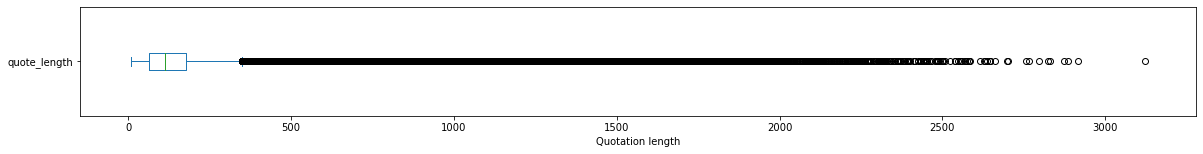

In [66]:
_ = df["quote_length"].plot(kind='box', figsize = [20, 2], vert=False) 
_ = plt.xlabel('Quotation length')

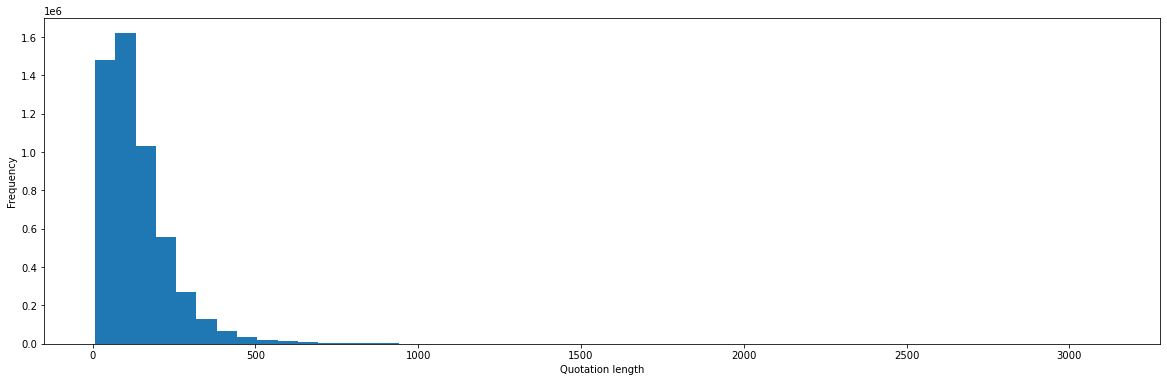

In [67]:
_ = df["quote_length"].plot(kind='hist', bins=50, figsize = [20, 6])
_ = plt.xlabel('Quotation length')

#### Occurrences distribution

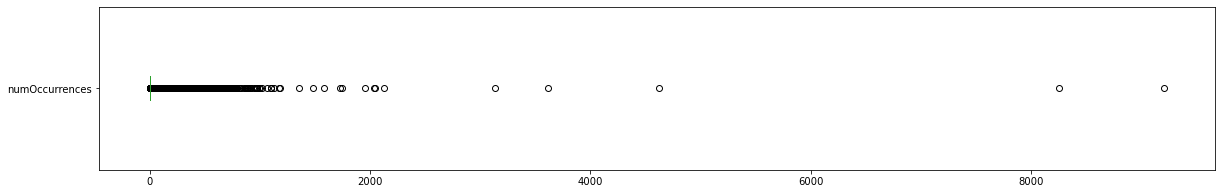

In [68]:
_ = df['numOccurrences'].plot(kind='box', figsize = [20, 3], vert=False)

In [85]:
# Most occuring quote
qb.where(qb.numOccurrences == df['numOccurrences'].max()).show(n = 10, vertical=True, truncate=100)

-RECORD 0--------------------------------------------------------------------------------------------------------------
 date           | 2020-02-28 14:08:52                                                                                  
 numOccurrences | 9210                                                                                                 
 phase          | E                                                                                                    
 probas         | [[None, 0.6861], [Mike Holmes, 0.3066], [Hideki Kamiya, 0.0065], [Sam Bishop, 8.0E-4]]               
 qids           | []                                                                                                   
 quotation      | something we talk about a lot                                                                        
 quoteID        | 2020-02-28-057818                                                                                    
 speaker        | None                  

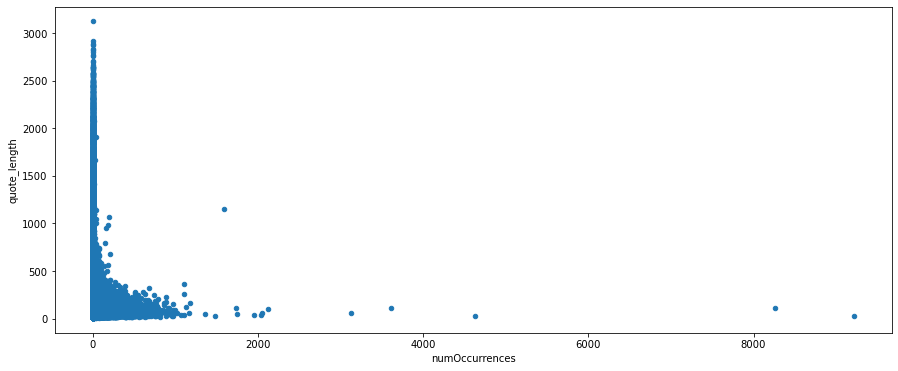

In [90]:
# Visualize plot between quote length and occurrences 
_ = df.plot(kind='scatter', x='numOccurrences', y='quote_length', figsize = [20, 6])

Observation: shorter quotes tend to be more cited.

### Exploring speakers

#### Speaker frequency

In [95]:
speaker_freq = qb.groupby("speaker_qid").count().sort("count", ascending=False).toPandas()
speaker_freq.head(15)

,speaker_qid,count
0,None,1800844
1,Q22686,48544
2,Q359442,13304
3,Q6279,12937
4,Q11673,11133
5,Q1058,8239
6,Q434706,7672
7,Q180589,7044
8,Q573246,6843
9,Q1286476,6734


In [96]:
speaker_freq = qb.groupby("speaker").count().sort("count", ascending=False).toPandas()
speaker_freq.head(15)

,speaker,count
0,None,1800844
1,President Donald Trump,28023
2,Bernie Sanders,13189
3,Joe Biden,12817
4,President Trump,12415
5,Andrew Cuomo,11088
6,Narendra Modi,8239
7,Elizabeth Warren,7647
8,Donald Trump,7104
9,Boris Johnson,6952


In [97]:
speaker_freq[1:].describe() # without None

,count
count,218414.000000
mean,15.766411
std,112.704624
min,1.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,28023.000000


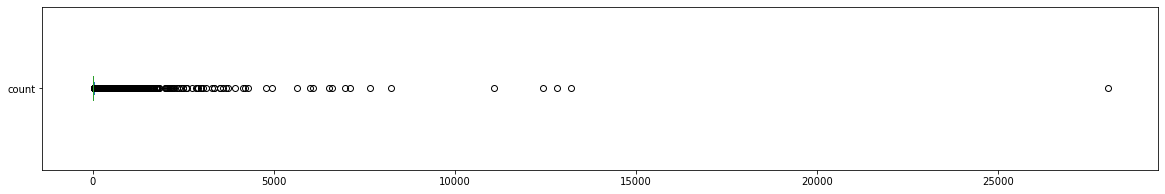

In [98]:
_ = speaker_freq[1:].plot(kind='box', figsize = [20, 3], vert=False) # without None

#### Quote distributions by speaker demographics

In [100]:
def demographic_stats(qb, colname):
    stats = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .withColumn(colname, f.explode(colname + '_labels')) \
    .groupby(colname) \
    .agg(f.count('quotation').alias('count')) \
    .sort('count', ascending=False).limit(50).toPandas()
    stats[colname + '_label'] = stats[colname].apply(lambda qid : labels.Label[qid])
    return stats

def plot_info(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot_demographic(stats, colname):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(y=colname + '_label', x='count', data=stats)
    plot_info('Number of quotes by ' + colname, 'Number of quotes', colname.title())
    return ax

We observe the following:
 - A significant number of quotes doesn't have an attributed speaker
 - The same speaker can have multiple differing labels (e.g. Donald Trump and President Donald Trump)
 - It is better to identify speakers by their QIDs

#### By occupation

In [101]:
occupation_stats = demographic_stats(qb, 'occupation')

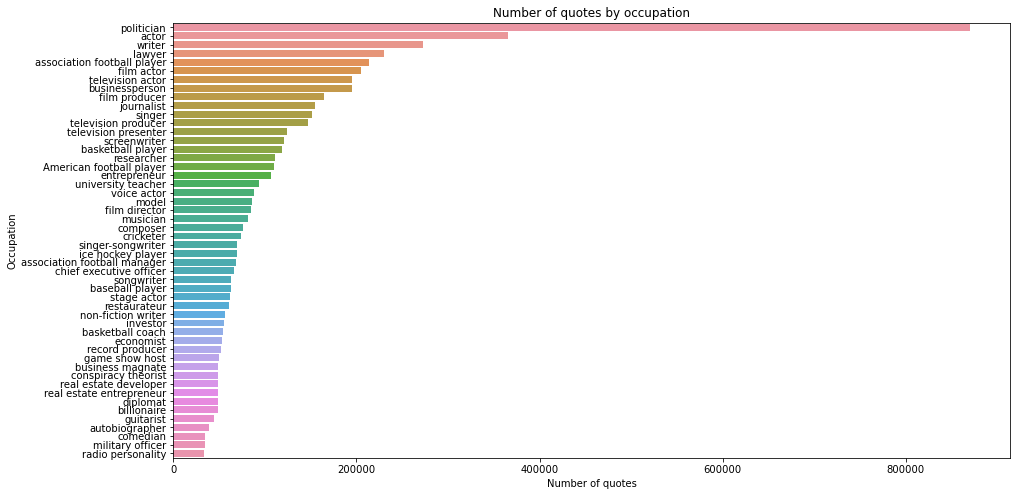

In [102]:
ax = plot_demographic(occupation_stats, 'occupation')

#### By gender

In [104]:
stats = demographic_stats(qb, 'gender')

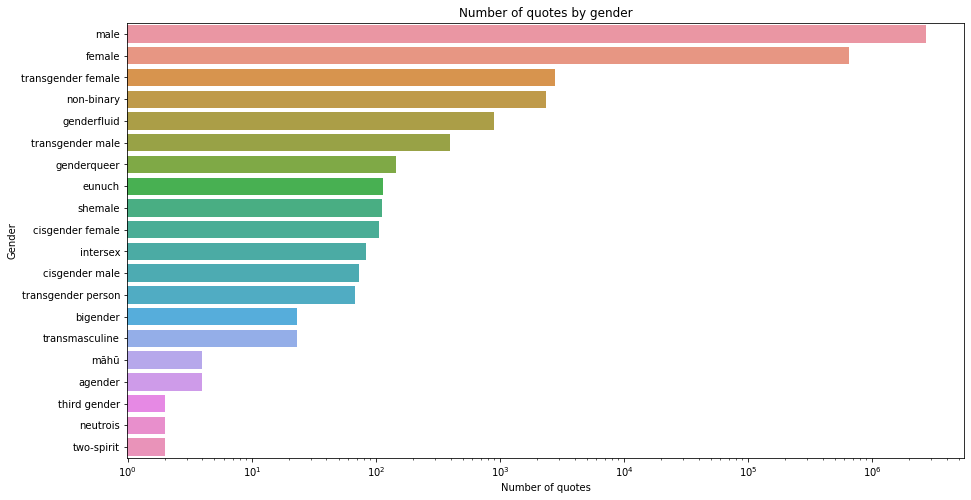

In [105]:
ax = plot_demographic(stats, 'gender')
ax.set_xscale('log')

#### By nationality

In [107]:
nationality_stats = demographic_stats(qb, 'nationality')

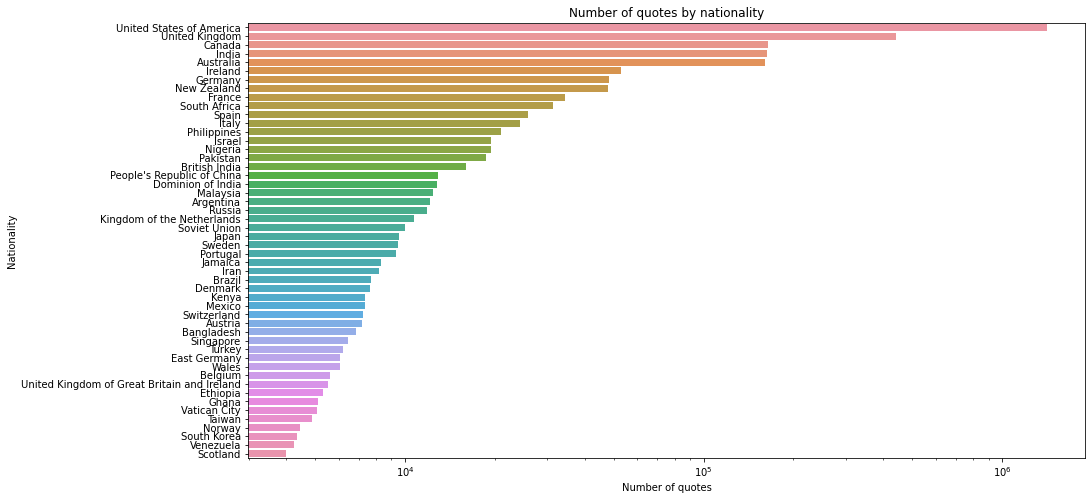

In [108]:
ax = plot_demographic(nationality_stats, 'nationality')
ax.set_xscale('log')

#### By ethnic group

In [109]:
ethnic_group_stats = demographic_stats(qb, 'ethnic_group')

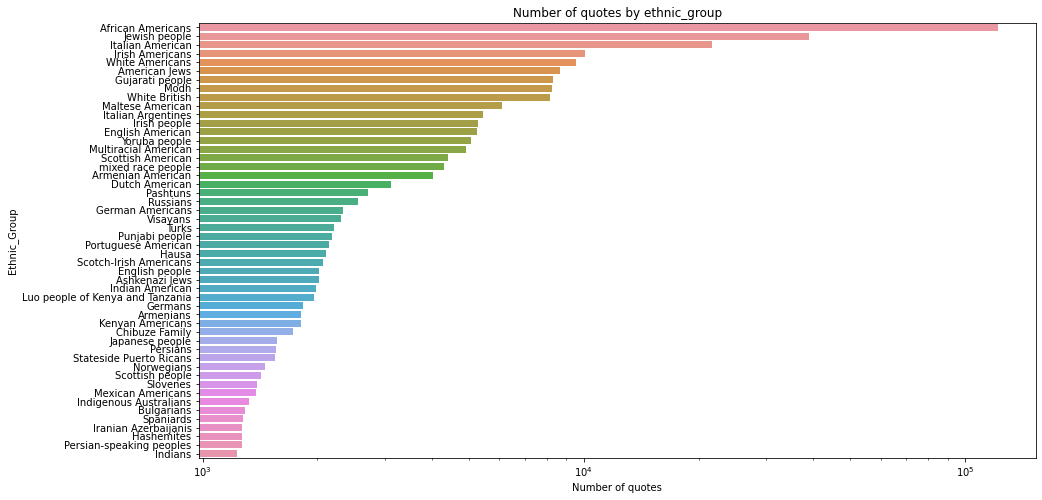

In [110]:
ax = plot_demographic(ethnic_group_stats, 'ethnic_group')
ax.set_xscale('log')

#### By religion

In [111]:
religion_stats = demographic_stats(qb, 'religion')

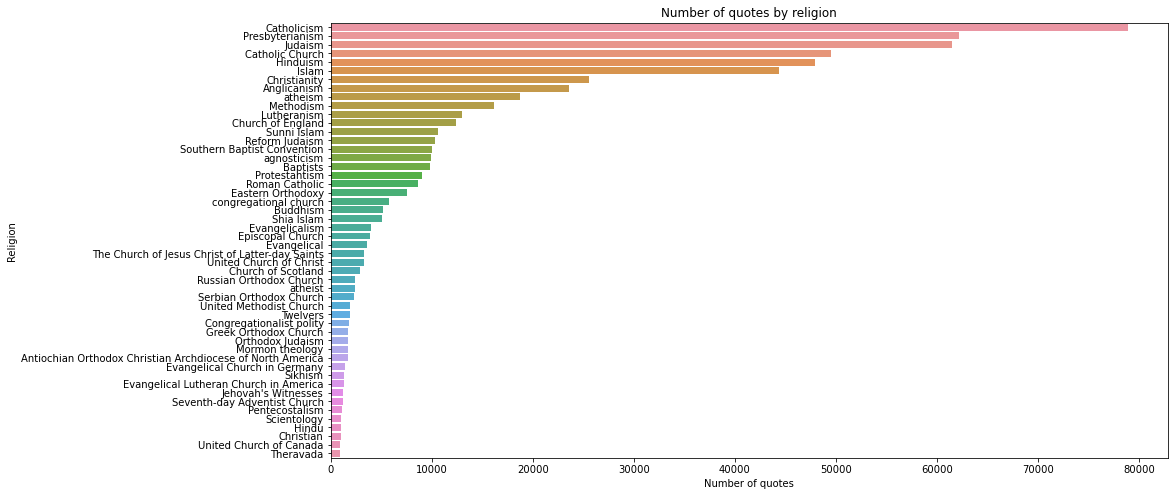

In [112]:
ax = plot_demographic(religion_stats, 'religion')

#### By political party

In [114]:
party_stats = demographic_stats(qb, 'party')

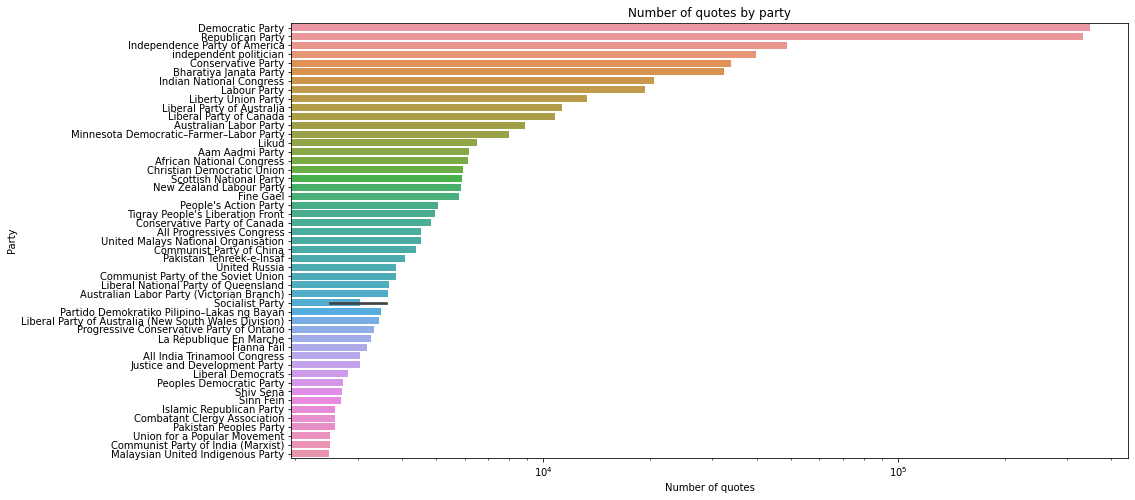

In [115]:
ax = plot_demographic(party_stats, 'party')
ax.set_xscale('log')

#### By academic degree

In [116]:
academic_degree_stats = demographic_stats(qb, 'academic_degree')

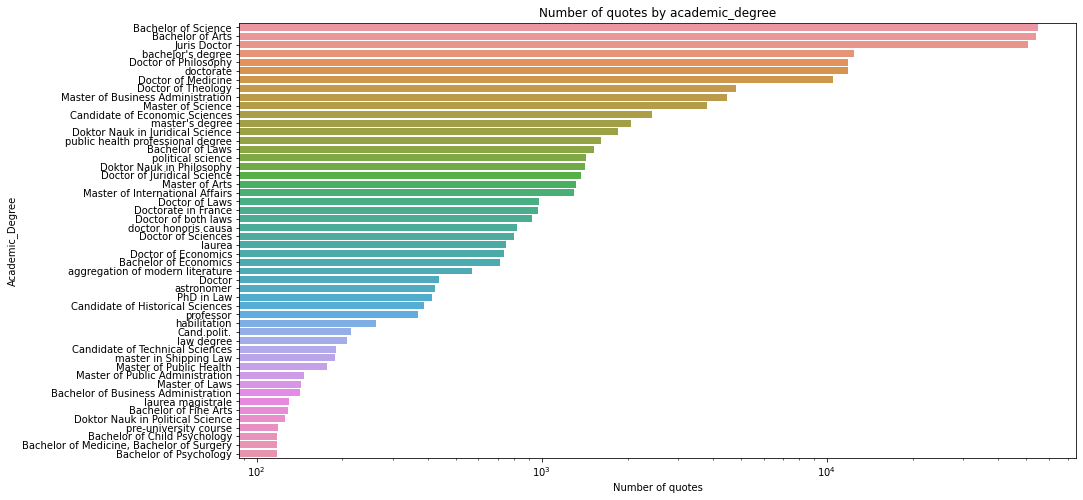

In [117]:
ax = plot_demographic(academic_degree_stats, 'academic_degree')
ax.set_xscale('log')

#### By year of birth

In [159]:
@f.udf(IntegerType())
def get_year(dob_list):
    return int(dob_list[0][0:5])

In [160]:
qb_yob = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth'))

In [161]:
yob_stats = qb_yob.groupby('birth_year').count().sort('birth_year').toPandas()

<AxesSubplot:xlabel='birth_year'>

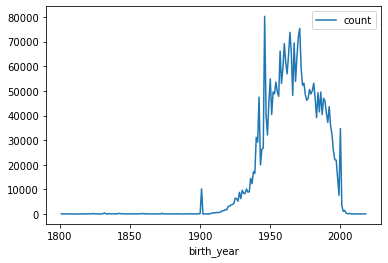

In [162]:
yob_stats[yob_stats.birth_year > 1800].plot.line(x='birth_year', y='count')

In [163]:
top_before_1950 = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth')) \
    .where(f.col('birth_year') < 1950) \
    .groupby('speaker').count().sort('count', ascending=False).toPandas()

In [165]:
top_before_1950.head(20)

,speaker,count
0,President Donald Trump,28023
1,Bernie Sanders,13189
2,Joe Biden,12817
3,President Trump,12415
4,Elizabeth Warren,7647
5,Donald Trump,7104
6,Anthony Fauci,6508
7,Nancy Pelosi,5632
8,Pope Francis,4776
9,Michael Bloomberg,3348


In [164]:
top_after_1990 = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth')) \
    .where(f.col('birth_year') > 1990) \
    .groupby('speaker').count().sort('count', ascending=False).toPandas()

In [167]:
top_after_1990.head(20)

,speaker,count
0,Justin Bieber,2010
1,Selena Gomez,1628
2,Billie Eilish,1603
3,Demi Lovato,1261
4,Kevin McCarthy,1139
5,Greta Thunberg,1117
6,Brendan Rodgers,1076
7,Kylie Jenner,1014
8,Nick Kyrgios,915
9,Cardi B,866


### Exploring Media Sources

In [128]:
# Top 20 most frequent domains. The number may seem high, but this is becauase the same quote can appear in multiple articles.
domain_counts = df.where(f.col('date').rlike('^2020'))\
                .select(f.explode(f.udf(url_list_to_tlds, ArrayType(StringType()))(f.col('urls'))).alias('tld'))\
                .groupby('tld')\
                .count()\
                .sort('count', ascending=False)\
                .show()

+---------------+------+
|            tld| count|
+---------------+------+
|        einnews|267567|
|            msn|241598|
|        news965|127998|
|           wokv|119616|
|businessinsider|102126|
|      breitbart| 98428|
|washingtontimes| 81833|
|       wsbradio| 77257|
|     indiatimes| 75690|
|      nbcsports| 72913|
|        nytimes| 70478|
|        foxnews| 66660|
|         sfgate| 64866|
|    gamereactor| 57670|
|    independent| 56300|
|        nbcnews| 55788|
|            smh| 54683|
|         newsok| 54674|
|           krmg| 54602|
|          stuff| 53077|
+---------------+------+
only showing top 20 rows



### Exploring Profanity

#### Visualize profanity score distribution

In [120]:
df_prof = qb.select("profanity").toPandas()

In [125]:
df_prof.describe()

,profanity
count,5.244449e+06
mean,6.039174e-02
std,1.001643e-01
min,1.231420e-04
25%,1.436037e-02
50%,3.006656e-02
75%,6.345237e-02
max,1.000000e+00


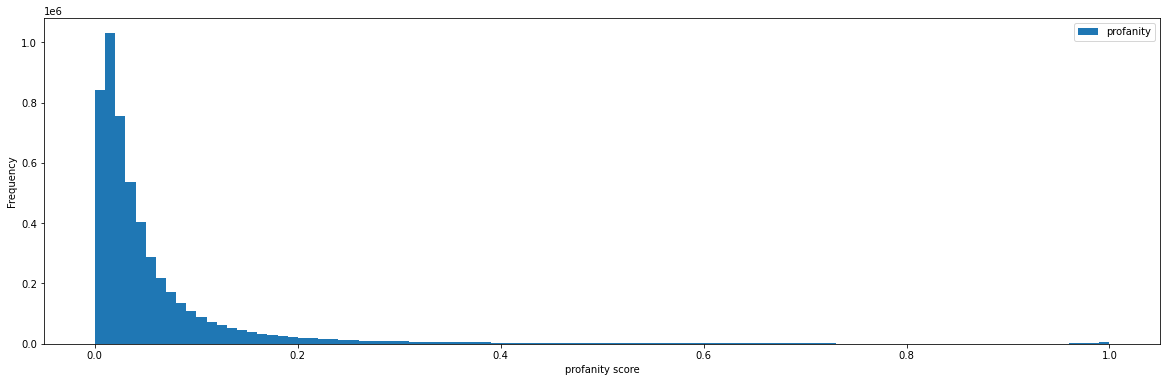

In [126]:
_ = df_prof.plot(kind='hist', bins=100, figsize = [20, 6])
_ = plt.xlabel('profanity score')

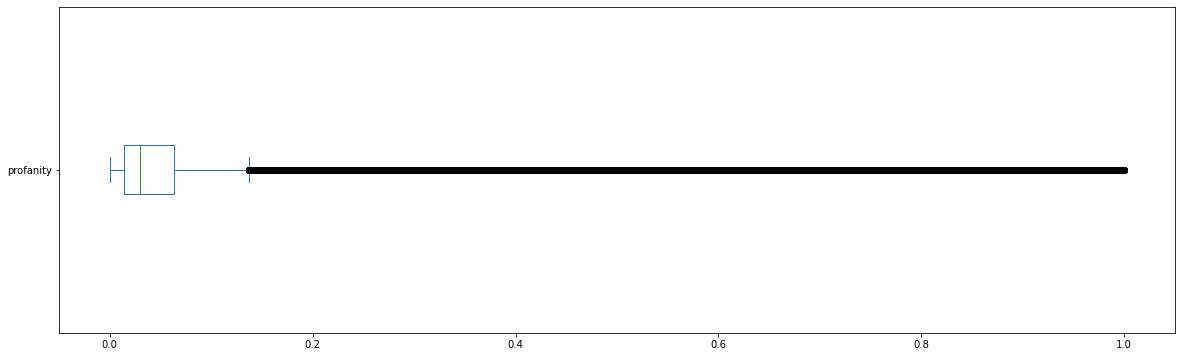

In [127]:
_ = df_prof.plot(kind='box', figsize=[20, 6], vert=False)

We use a threshold of 0.7 to identify high profanity quotes. This value will be finalized later.

In [128]:
PROF_THRESHOLD = 0.7

In [130]:
df_profane = qb.where(qb.profanity > PROF_THRESHOLD).toPandas()
df_profane.head()

,date,numOccurrences,phase,probas,qids,quotation,quoteID,speaker,urls,speaker_qid,speaker_prob,tlds,profanity
0,2020-03-02 15:02:27,2,E,"[[John Oliver, 0.8773], [None, 0.107], [Mike P...","[Q1701249, Q1701254, Q21598301, Q22279481, Q47...","Don't be complacent, and don't be a f -- ing i...",2020-03-02-011684,John Oliver,[https://www.onenewspage.com/n/US/1zlqy6wejc/J...,Q1701249,0.8773,"[onenewspage, thewrap]",0.999671
1,2020-02-04 11:19:14,1,E,"[[None, 0.6552], [Justin Scott, 0.2545], [03 G...",[],"Fuck Cozy Boys II,",2020-02-04-021291,None,[https://www.highsnobiety.com/p/j-scott-asap-m...,None,0.6552,[highsnobiety],0.999760
2,2020-02-14 19:00:19,1,E,"[[John Zogby, 0.8239], [None, 0.1574], [Presid...",[Q6265340],have expressed not even so much a problem with...,2020-02-14-023051,John Zogby,[https://www.washingtonexaminer.com/washington...,Q6265340,0.8239,[washingtonexaminer],0.727978
3,2020-03-13 14:14:51,1,E,"[[Kate Beckinsale, 0.9123], [None, 0.0877]]",[Q179414],he started screaming `you stupid fucking C -- ...,2020-03-13-018338,Kate Beckinsale,[http://origin.thehollywoodgossip.com/2020/03/...,Q179414,0.9123,[thehollywoodgossip],0.999828
4,2020-03-25 17:22:07,1,E,"[[Dave Grohl, 0.6925], [None, 0.3075]]",[Q12006],I look forward to sharing some of the more rid...,2020-03-25-026127,Dave Grohl,[https://myspace.com/article/2020/3/25/dave-gr...,Q12006,0.6925,[myspace],0.980689


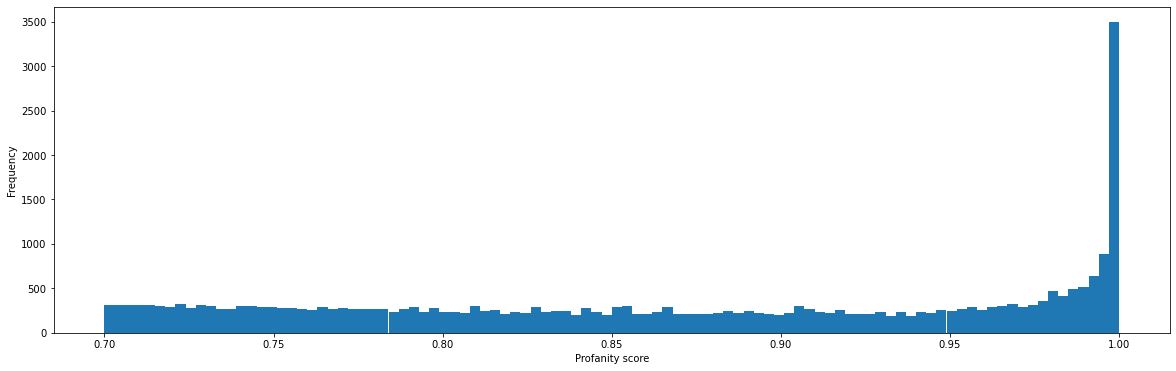

In [133]:
_ = df_profane['profanity'].plot(kind='hist', bins=100, figsize=[20, 6])
_ = plt.xlabel('Profanity score')

In [134]:
# Quote most common with highest profanity 
df_profane.iloc[df_profane['numOccurrences'].argmax()]

date                                            2020-04-06 00:00:00
numOccurrences                                                  441
phase                                                             E
probas            [[Thomas Modly, 0.5532], [None, 0.3445], [Pres...
qids                                                    [Q41598755]
quotation                                  too naive or too stupid,
quoteID                                           2020-04-06-053110
speaker                                                Thomas Modly
urls              [http://hpr2.org/post/navy-leader-calls-fired-...
speaker_qid                                               Q41598755
speaker_prob                                                 0.5532
tlds              [hpr2, kob, kpbs, foxnews, seattletimes, nbclo...
profanity                                                  0.960096
Name: 3151, dtype: object

In [136]:
# Quote with highest profanity
df_profane.loc[df_profane['profanity'].argmax()] # Highest profanity quote

date                                            2020-01-27 18:40:00
numOccurrences                                                    1
phase                                                             E
probas            [[None, 0.8483], [Matthew Keys, 0.1024], [Kobe...
qids                                                             []
quotation            Piece of fucking shit. Go fuck yourself. Cunt.
quoteID                                           2020-01-27-058755
speaker                                                        None
urls              [https://www.vox.com/2020/1/27/21083682/kobe-b...
speaker_qid                                                    None
speaker_prob                                                 0.8483
tlds                                                          [vox]
profanity                                                       1.0
Name: 29108, dtype: object

#### Most frequent words in high profanity quotations

In [197]:
words = df_profane.quotation.str.split(expand=True).stack()

In [200]:
stopword_set = set(stopwords.words())

In [201]:
filtered_words = pd.Series(filter(lambda word: word.lower() not in stopword_set, words))

In [202]:
filtered_words.value_counts().head(20)

I'm        3633
like       3542
get        2392
--         2315
going      2299
f          2031
fucking    1955
people     1928
got        1700
know       1691
*          1566
shit       1527
would      1374
stupid     1365
like,      1339
[          1282
go         1226
kill       1187
think      1181
fuck       1135
dtype: int64

#### Speaker frequency in high profanity quotations

In [203]:
df_profane['speaker'].value_counts().head(15)

None                      12195
President Donald Trump      229
President Trump             125
Cardi B                     125
Billie Eilish               124
Bernie Sanders              120
Pete Davidson               103
Snoop Dogg                   88
Boosie Badazz                83
Piers Morgan                 82
Megan Thee Stallion          76
Donald Trump                 75
Taylor Swift                 71
Chrissy Teigen               70
50 Cent                      69
Name: speaker, dtype: int64

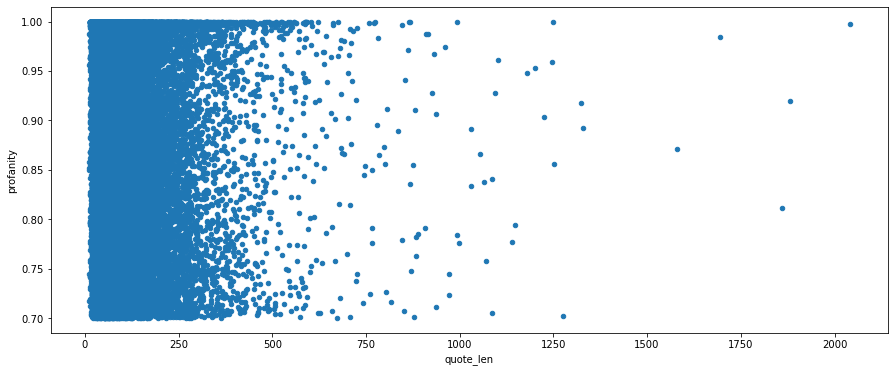

In [146]:
df_profane['quote_len'] = df_profane['quotation'].apply(len)
_ = df_profane.plot(kind='scatter', x='quote_len', y='profanity', figsize=[15, 6]) # No visible correlation

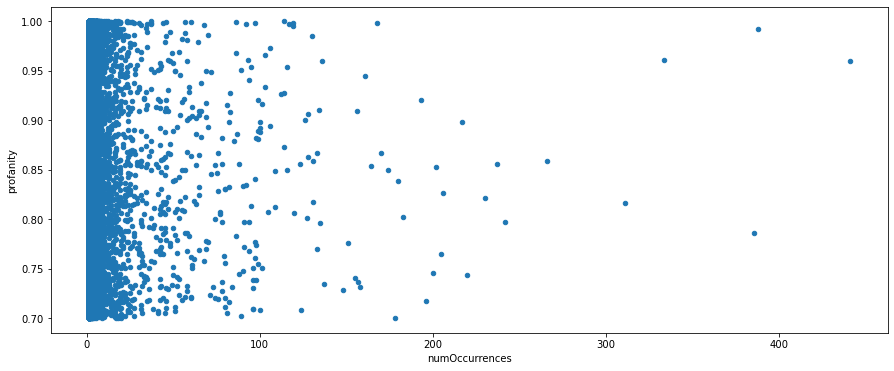

In [147]:
_ = df_profane.plot(kind='scatter', x='numOccurrences', y='profanity', figsize=[15, 6])

#### Most profane speakers

In [153]:
qb.groupby('speaker').agg(f.avg('profanity').alias('avg_profanity')).sort('avg_profanity', ascending=False).toPandas().head(10)

,speaker,avg_profanity
0,Jan Peter,1.000000
1,Elisapee Sheutiapik,1.000000
2,JOE ROGAN,1.000000
3,Christian Winter,0.999995
4,Piotr Wiwczarek,0.999994
5,Richard Desmond,0.999990
6,Jamie Zawinski,0.999988
7,jay z,0.999975
8,Daniel Ehrenhaft,0.999971
9,Richard Pennington,0.999971


In [155]:
trump_qid = "Q22686"
df_trump = qb.where(qb.speaker_qid == trump_qid).toPandas()

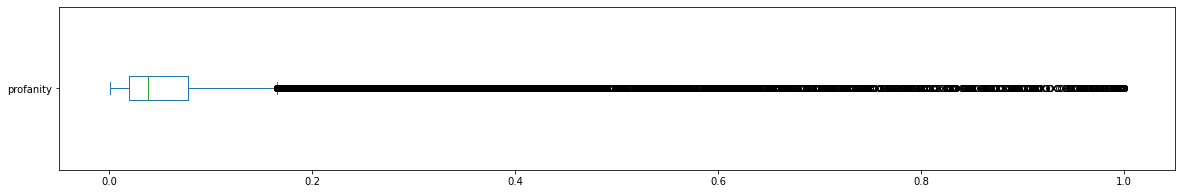

In [157]:
_ = df_trump['profanity'].plot(kind='box', figsize=[20, 3], vert=False) # Trump profanity distribution

#### Profanity distribution by speaker demographics

#### Profanity by speaker occupations

In [189]:
def demographic_profanity(qb, colname, min_quotes):
    df = prof_by_occupation = qb.where(qb.speaker_qid.isNotNull()) \
        .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
        .withColumn(colname, f.explode(colname + '_labels')) \
        .groupby(colname) \
        .agg(f.avg('profanity').alias('avg_profanity'), f.count('quotation').alias('count')) \
        .where(f.col('count') >= min_quotes) \
        .sort('avg_profanity', ascending=False).limit(10).toPandas()
    df[colname + '_label'] = df[colname].apply(lambda qid: labels.Label[qid])
    return df

In [190]:
df_prof = demographic_profanity(qb, 'occupation', 1000)

<AxesSubplot:xlabel='occupation_label', ylabel='avg_profanity'>

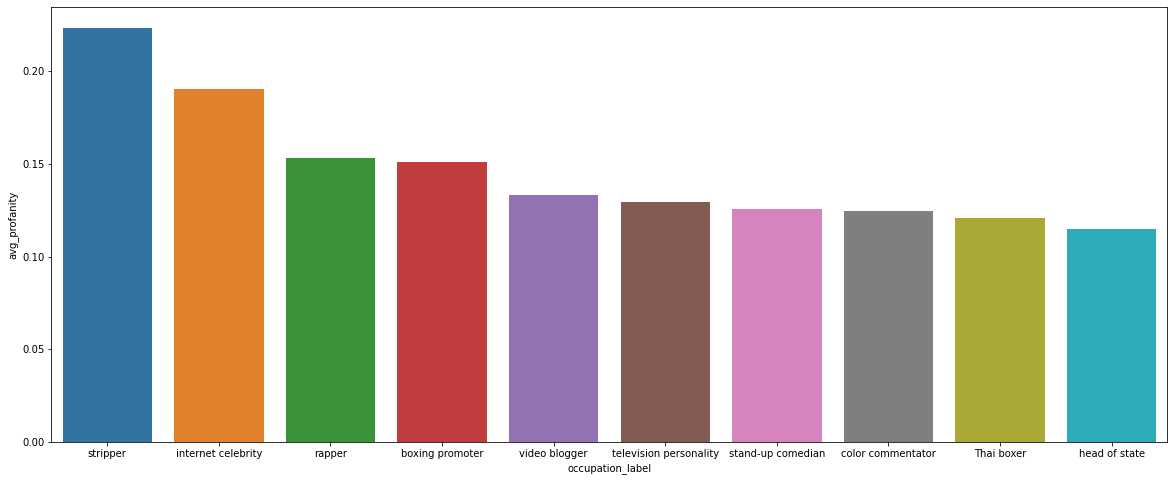

In [193]:
plt.figure(figsize=(20,8))
sns.barplot(x='occupation_label', y='avg_profanity', data=df_prof)

#### Profanity by speaker gender

In [177]:
qb_hp = qb.where(qb.profanity > PROF_THRESHOLD)

In [178]:
all_quotes = qb.where(qb.speaker_qid.isNotNull()).count()
hp_quotes = qb_hp.where(qb.speaker_qid.isNotNull()).count()

In [179]:
gender_stats_all = demographic_stats(qb, 'gender')
gender_stats_hp = demographic_stats(qb_hp, 'gender')

In [180]:
gender_stats_all['kind'] = 'all'
gender_stats_all['fraction'] = gender_stats_all['count'] / all_quotes
gender_stats_hp['kind']='high_profanity'
gender_stats_hp['fraction'] = gender_stats_hp['count'] / hp_quotes
gender_stats_cat = pd.concat([gender_stats_all, gender_stats_hp])
gender_stats_cat = gender_stats_cat[gender_stats_cat.fraction > 0.01]
gender_stats_cat

,gender,count,gender_label,kind,fraction
0,Q6581097,2726341,male,all,0.791711
1,Q6581072,648546,female,all,0.188333
0,Q6581097,13780,male,high_profanity,0.735954
1,Q6581072,4630,female,high_profanity,0.247276


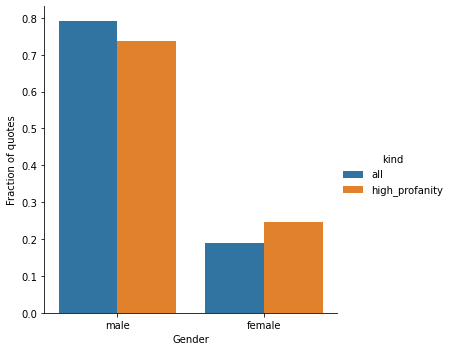

In [182]:
sns.catplot(x='gender_label', y='fraction', hue='kind', kind='bar', data=gender_stats_cat)
plt.xlabel('Gender')
plt.ylabel('Fraction of quotes');

#### Top news domains with high profanity quotes

In [ ]:
def profanity_by_news_outlet(df, min_quotes = 10000):
    return df \
        .withColumn('tld', f.explode('tlds')) \
        .groupby('tld') \
        .agg(f.avg('profanity').alias('avg_profanity'), f.count('quotation').alias('count')) \
        .where(f.col('count') >= min_quotes) \
        .sort('avg_profanity', ascending=False)

In [ ]:
profanity_by_news_outlet(qb, 10000).toPandas().head(20)

,tld,avg_profanity,count
0,nme,0.123961,10657
1,thehollywoodgossip,0.101081,12271
2,inquisitr,0.093002,23046
3,eonline,0.088969,11800
4,thedailybeast,0.088715,13377
5,cheatsheet,0.088293,29177
6,etcanada,0.088131,10862
7,thesun,0.087975,35166
8,usmagazine,0.085605,13111
9,people,0.085066,26263


## Temporal Analysis

In [64]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

@f.udf(StringType())
def get_date(date_str):
    return "-".join(date_str.split("-")[:3])

def normalize(key, pdf):
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

def plot_distribution(df, title):
    plt.figure(figsize=(6,8))
    plt.ylim(0.99 * df['mean'].min(), 1.01 * df['mean'].max())
    sns.barplot(x=df["key"], y=df["mean"], yerr=1.96*df["sem"])
    plt.xlabel("month")
    plt.ylabel("average profanity with 95% error bars")
    plt.title(title)
    plt.show()

#### Moving average of profanities

In [49]:
daily_avg = qb \
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [52]:
daily_avg = daily_avg.set_index('key')
mavg = daily_avg.rolling(14).mean()

/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


<AxesSubplot:xlabel='key'>

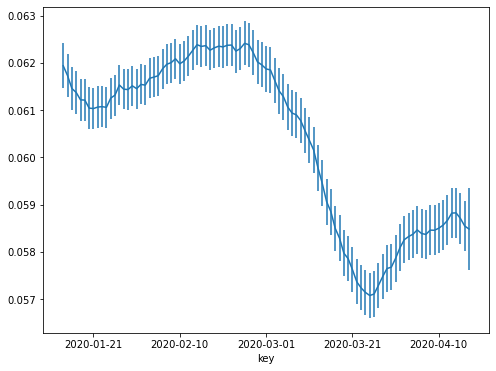

In [58]:
plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'])

#### Monthly average profanity

In [67]:
d1 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [68]:
d2 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .where( (qb.speaker != "President Donald Trump") \
               & (qb.speaker != "President Trump") \
               & (qb.speaker != "Donald Trump") ) \
        .groupby("date") \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

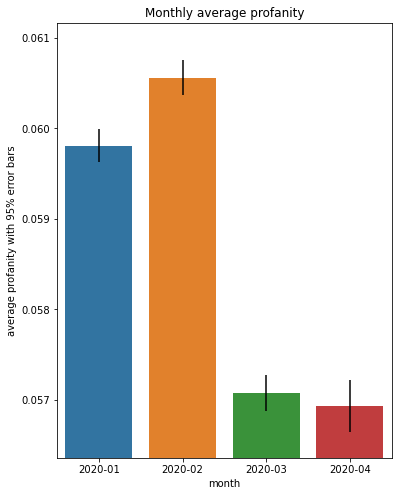

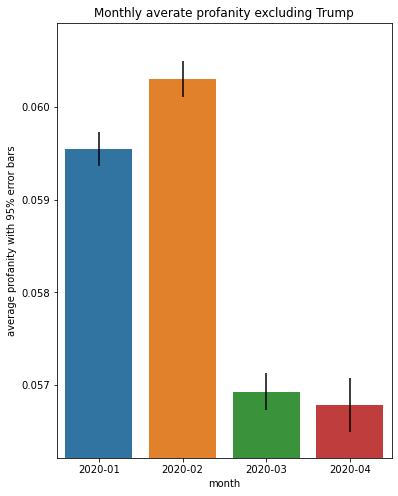

In [69]:
plot_distribution(d1, "Monthly average profanity")
plot_distribution(d2, "Monthly averate profanity excluding Trump")

#### Profanity with and without Donald Trump

(0.05621509567879076, 0.06116344827488733)

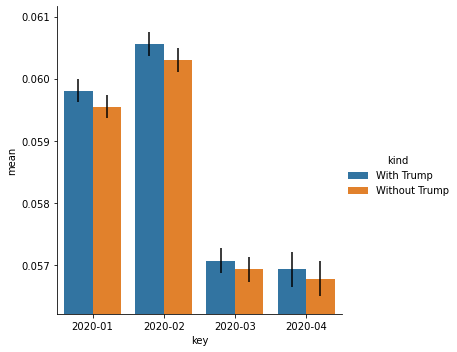

In [70]:
d1['kind'] = 'With Trump'
d2['kind'] = 'Without Trump'
d = pd.concat([d1, d2])
sns.catplot(x='key', y='mean', hue='kind', data=d, kind='bar', yerr=1.96 * d1['sem'])
plt.ylim(0.99 * d['mean'].min(), 1.01 * d['mean'].max())

## Sentiment analysis with SparkNLP

In [8]:
# Loading the model
pipeline = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [ ]:
# Calculating sentiments of the quotes. We will select only the quoteID, sentiment, and classifier confidence so that the sentiments can be joined with other data.
sentiment = pipeline.fullAnnotate(df.where(f.col('date').rlike('^2020')), column='quotation')\
                    .select('quoteID',
                            f.col('sentiment.result').getItem(0).alias('sentiment'),
                            f.col('sentiment.metadata').getItem(0).confidence.alias('confidence'))

# Save sentiment sentiment scores for 2020 data so that they don't have to be recomputed
sentiment.write.parquet('data/2020-sentiments.parquet')

# It took ~43 minutes to calculate sentiments for the 2020 data. For the entire data it would then take ~16 hours, which is doable.

In [68]:
sentiment = spark.read.parquet('data/2020-sentiments.parquet')

# Join the datasets
df = df.join(sentiment, on='quoteID')

In [ ]:
# Overall sentiment distribution
sentiment_counts = df.groupby('sentiment').count().toPandas()

<AxesSubplot:title={'center':'Overall sentiment distribution'}, xlabel='sentiment', ylabel='count'>

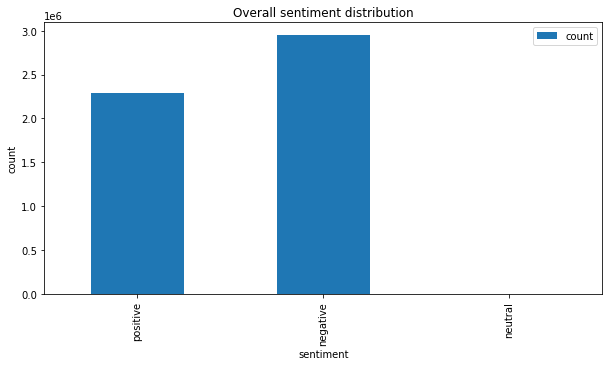

In [64]:
sentiment_counts.loc[sentiment_counts['sentiment'] == 'na', 'sentiment'] = 'neutral'
sentiment_counts.plot.bar(x='sentiment', y='count', figsize=[10, 5], title='Overall sentiment distribution', ylabel='count')

'na' sentiment actually corresponds to the situation where the classifier is confident neither in positive nor negative sentiment. Here we refer to it is neutral, but as it can be seen, this portion is rather small. Currently, by default, the classifier assigns 'na' label only when its confidence is zero (as it can be seen below) so the overall distribution may change if we decide to use some higher confidence threshold. 

In [66]:
df.where((f.col('confidence') < 1e-6)).groupby('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|       na| 3390|
+---------+-----+



In [171]:
# Count quotes with positive and negative sentiment for each speaker
speaker_sentiments = df.where(f.col('speaker') != 'None')\
                        .groupby('speaker', 'sentiment')\
                        .agg(f.count('quoteID').alias('count'))\
                        .toPandas()

# Counts -> percenages per speaker
speaker_sentiments.head()

,speaker,sentiment,count
0,Veng Sakhon,negative,7
1,Amarinder Singh,negative,395
2,Lynn Hamilton,negative,23
3,Reilly Smith,negative,32
4,Christian Diaz,negative,7


In [7]:
def replace_value(df, column, value_old, value_new):
    """Replaces a given value in a given column of a dataframe with a new one"""
    df.loc[df[column] == value_old, column] = value_new
    return df

# Calculate average sentiments
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'positive', 1)
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'negative', -1)
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'na', 0)

speaker_sentiments.head()

In [183]:
# We are only considering the speakers with 1000 or more quotes
more_than_1000_speakers = set([i.speaker for i in df.groupby('speaker')
                                                   .agg(f.count('quoteID').alias('count'))
                                                   .where(f.col('count') >= 1000).collect()])

In [196]:
# Computing average sentiment for each speaker
speaker_sentiments = speaker_sentiments[speaker_sentiments['speaker'].isin(more_than_1000_speakers)]
speaker_sentiments['sentiment_sum'] = speaker_sentiments['sentiment'] * speaker_sentiments['count']
value_sums = speaker_sentiments.groupby('speaker').sum(0)
average_sentiments = value_sums['sentiment_sum'] / value_sums['count']

most_negative = average_sentiments.nsmallest(10)
most_positive = average_sentiments.nlargest(10)

In [197]:
most_negative

speaker
Nick Nurse        -0.306852
Jimmy Kimmel      -0.261181
Piers Morgan      -0.248230
Stephen Colbert   -0.247863
Rush Limbaugh     -0.246301
Jim Cramer        -0.236842
Francisco Duque   -0.236111
Tucker Carlson    -0.234508
William Barr      -0.220322
Pope Francis      -0.214615
dtype: float64

In [198]:
most_positive

speaker
Selena Gomez          0.041769
Dwyane Wade           0.039537
Virat Kohli          -0.001448
Rafael Nadal         -0.001946
Demi Lovato          -0.026170
Tom Steyer           -0.027656
Gladys Berejiklian   -0.028571
Jessica Simpson      -0.031161
Billie Eilish        -0.036806
Taylor Swift         -0.044223
dtype: float64

In [10]:
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

@f.udf(StringType())
def get_date(date_str):
    return "-".join(date_str.split("-")[:3])

def normalize_sentiment(key, pdf):
    pdf = replace_value(pdf, 'sentiment', 'positive', 1)
    pdf = replace_value(pdf, 'sentiment', 'negative', -1)
    pdf = replace_value(pdf, 'sentiment', 'na', 0)
    
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.sentiment.mean() ], "sem" : [ pdf.sentiment.sem() ]})

In [12]:
# Moving average of sentiment
sentiment_through_time = df \
        .select('quoteID', 'sentiment')\
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize_sentiment, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas() \
        .set_index('key')

In [13]:
mavg = sentiment_through_time.rolling(14).mean()

# EMPATH
Here we simply analyze whether it is feasible to use EMPATH.

In [69]:
lexicon = Empath()
get_aggression = f.udf(lambda x: lexicon.analyze(x, categories=['aggression'], normalize=True)['aggression'], FloatType())

In [80]:
aggressions = df.where(f.col('date').rlike('^2020'))\
                       .select('quoteID', get_aggression(f.col('quotation')).alias('aggression')) # Get aggression scores
aggressions.write.parquet('data/2020-aggression.parquet') # Save the data to memory

# Assigning aggression scores on the 2020 data took only ~2 minutes, which means it would take ~46 minutes for the entire data, which is fine.
# However it is important to note that this number will be multiplied by the number of categories that we opt for.

In [81]:
# Load aggression scores
aggressions = spark.read.parquet('data/2020-aggression.parquet')

In [92]:
def normalize_sentiment(key, pdf):
    pdf = replace_value(pdf, 'aggression', 'positive', 1)
    pdf = replace_value(pdf, 'aggression', 'negative', -1)
    pdf = replace_value(pdf, 'aggression', 'na', 0)
    
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.aggression.mean() ], "sem" : [ pdf.aggression.sem() ]})

In [95]:
# A simple plot of aggression through time
ggression_through_time = aggressions \
        .select('quoteID', 'aggression')\
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize_sentiment, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas() \
        .set_index('key')

/home/maculjak/anaconda3/envs/ada/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


<AxesSubplot:xlabel='Date', ylabel='Average aggression'>

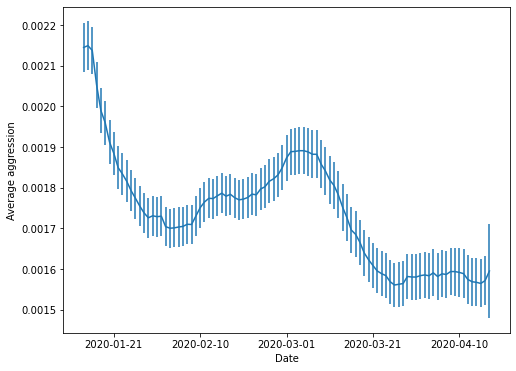

In [96]:
mavg = aggression_through_time.rolling(14).mean()

plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'], ylabel='Average aggression', xlabel='Date')

In [106]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None
